# Molecular Learning
Sept. 8, 2017 

### Import libraries 
This project will be using [scikit-learn](http://scikit-learn.org/stable/)'s Kernel Ridge Regression classifier for machine learning. 
To get started we need to import the necessary libraries as well as make sure we are properly calling openbabel.

In [1]:
import glob
import numpy as np
import pybel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import style
import csv

ob = pybel.ob


def atomType(mol, atomIdx):
    # get the atomic type given an atom index
    return mol.OBMol.GetAtom(atomIdx).GetType()


row_list = []


### Reading through molecular data
The next thing to do is read through all of the directories the files are contained in to be able to get bond, angle, and torsion information of the conformers

In [2]:
# Read through all the files in the folder of this directory
# for directory in glob.iglob("/Users/dakota/Documents/Research/conformers/*CHG_jobs/*"):
for directory in glob.iglob("/Users/dakota/Documents/Research/ForDakota/omegacsd_YAGWOS/*"):
    name = "/".join(directory.split('/')[0:2])  # name of the entry

    # for files in glob.iglob(directory + "/rmsd*.mol"):
    for files in glob.iglob(directory + "/rmsd*.out"):
        conf = files.split('/')[-1]  # conformer name/number

        try:
            # Use this for Python 2.7
            # mol = pybel.readfile('format', argument).next()
            # Use this for Python 3.6
            # readfile(format, filename)
            # mol = next(pybel.readfile('mol', files))
            mol = next(pybel.readfile('out', files))
        except:
            pass

        # In this case I do not include Energy as that is our dependent variable
        # ideally, we should turn this into an atomization energy
        energy = [mol.energy] # in kcal/mol

        # iterate through all atoms
        #  .. this is commented out because Bag Of Bonds doesn't use atomic charges
        # for atom in mol.atoms:
        #    print "Atom %d, %8.4f" % (atom.type, atom.partialcharge)

        bonds = []
        for bond in ob.OBMolBondIter(mol.OBMol):
            begin = atomType(mol, bond.GetBeginAtomIdx())
            end = atomType(mol, bond.GetEndAtomIdx())
            if (end < begin):
                # swap them for lexographic order
                begin, end = end, begin
            dict2 = {}
            bond_type = ("%s%s" % (begin[0], end[0]))
            bond_length = ("%8.4f" % (bond.GetLength()))
            dict2.update({'Bond Type': bond_type})
            dict2.update({'Bond Length': bond_length})
            bonds.append(dict2)

        dfb = pd.DataFrame(bonds, columns=['Bond Type', 'Bond Length'])
        # Encode the bond types into numerical representations for sklearn
        poss_types = {'CC': 0, 'CF': 1, 'CH': 2, 'CN': 3, 'CO': 4, 'CP': 5, 'CS': 6,
                      'HN': 7, 'HO': 8, 'OS': 9, 'OP': 10, 'NS': 11, 'NN': 12, 'NO': 13, 'BC': 14}
        dfb['Bond Type'] = dfb['Bond Type'].map(poss_types)
        # When iterating through molecueles with different number of bonds it will be 
        # .. important that the matrices are still the same length
        bond_difference = 500 - len(bonds)
        bond_extra = ([None] * bond_difference)
        dfb = pd.DataFrame.append(dfb, bond_extra)
        dfb = dfb.fillna(-99999)
        dfb.drop([0], inplace=True, axis=1)

        # iterate through all angles
        angles = []
        for angle in ob.OBMolAngleIter(mol.OBMol):
            a = (angle[0] + 1)
            b = mol.OBMol.GetAtom(angle[1] + 1)
            c = (angle[2] + 1)

            aType = atomType(mol, a)
            cType = atomType(mol, c)
            if (cType < aType):
                # swap them for lexographic order
                aType, cType = cType, aType
            dict3 = {}
            angle_type = ("%s-%s-%s" %
                          (aType[0], b.GetType()[0], cType[0]))
            angle_angle = ("%8.3f" % (b.GetAngle(a, c)))
            dict3.update({'Angle Type': angle_type})
            dict3.update({'Angle': angle_angle})
            angles.append(dict3)

        dfa = pd.DataFrame(angles, columns=['Angle Type', 'Angle'])
        # Encode the angle types into numerical representations for sklearn
        angle_encoding = pd.read_csv(
            '/Users/dakota/PycharmProjects/Research/MolecularLearning/molecular_learning/angle.csv')
        poss_angle_types = list(angle_encoding.set_index(
            'Angle').to_dict().values()).pop()
        dfa['Angle Type'] = dfa['Angle Type'].map(poss_angle_types)
        
        angle_difference = 500 - len(angles)
        angle_extra = ([None] * angle_difference)
        dfa = pd.DataFrame.append(dfa, angle_extra)
        dfa = dfa.fillna(-99999)
        dfa.drop([0], inplace=True, axis=1)

        # iterate through all torsions
#         torsions = []
#         for torsion in ob.OBMolTorsionIter(mol.OBMol):
#             a = (torsion[0] + 1)
#             b = (torsion[1] + 1)
#             c = (torsion[2] + 1)
#             d = (torsion[3] + 1)

#             aType = atomType(mol, a)
#             bType = atomType(mol, b)
#             cType = atomType(mol, c)
#             dType = atomType(mol, d)

#             dict4 = {}
#             # output in lexographic order
#             if (aType[0] < dType[0]):
#                 torsion_type = ("%s-%s-%s-%s" %
#                                 (aType[0], bType[0], cType[0], dType[0]))
#                 torsion_angle = ("%8.3f" %
#                                  (abs(mol.OBMol.GetTorsion(a, b, c, d))))
#                 dict4.update({'Torsion Type': torsion_type})
#                 dict4.update({'Torsion': torsion_angle})
#                 torsions.append(dict4)
#             else:
#                 torsion_type = ("%s-%s-%s-%s" %
#                                 (dType[0], cType[0], bType[0], aType[0]))
#                 torsion_angle = ("%8.3f" %
#                                  (abs(mol.OBMol.GetTorsion(a, b, c, d))))
#                 dict4.update({'Torsion Type': torsion_type})
#                 dict4.update({'Torsion': torsion_angle})
#                 torsions.append(dict4)

#         dftor = pd.DataFrame(torsions, columns=['Torsion Type', 'Torsion'])
#         # Encode the angle types into numerical representations for sklearn
#         torsion_encoding = pd.read_csv(
#             '/Users/dakota/PycharmProjects/Research/MolecularLearning/molecular_learning/torsion.csv')
#         poss_torsion_types = list(torsion_encoding.set_index(
#             'Torsion').to_dict().values()).pop()
#         dftor['Torsion Type'] = dftor['Torsion Type'].map(poss_torsion_types)

#         torsion_difference = 500 - len(torsions)
#         torsion_extra = ([None] * torsion_difference)
#         dftor = pd.DataFrame.append(dftor, torsion_extra)
#         dftor = dftor.fillna(-99999)
#         dftor.drop([0], inplace=True, axis=1)

        # store the bonds angles and torsions as molecule descriptors
        # molecule_descriptor = pd.concat(
        #     [dfb['Bond Type'], dfb['Bond Length'], dfa['Angle Type'], dfa['Angle'], dftor['Torsion Type'], dftor['Torsion']])
        molecule_descriptor = pd.concat(
            [dfb['Bond Type'], dfb['Bond Length'], dfa['Angle Type'], dfa['Angle']])
        # molecule_descriptor = pd.concat([dfb['Bond Type'], dfb['Bond Length']])
        
        # store the descriptors for the molecules in a dictionary
        dict1 = {}
        dict1.update({'Molecule': molecule_descriptor})
        dict1.update({'Name': name})
        dict1.update({'Conformer': conf})
        dict1.update({'Energy': energy})
        row_list.append(dict1)
        
        
# Make a dataframe of all the molecules, their descriptors and energies
df = pd.DataFrame(row_list, columns=[
    'Name', 'Conformer', 'Molecule', 'Energy'])


/Users/dakota/anaconda/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


### Organization for scikit-learn
Now that all of the molecule information is in a dataframe, we need to create an array of the molecule information and corresponding energy information

In [3]:
molecules = df['Molecule']
Energy = df['Energy']

X = np.asarray(list(molecules), dtype=np.float)
y = np.asarray(list(Energy), dtype=np.float)


### Training and Learning
From here we can split the molecules up into training and test sets using sklearn. The training set is roughly 80% of the total data set of molecules. 

The classifier that we are using in Kernel Ridge Regression with the radial basis function(Gaussian) kernel. 

The r^2 values and Mean Absolute Error values are included in order to determine how well the ML is doing at predicting energy values.

Finally a dataframe is made in order to easily compare the predicted and actual energy values of the test set. This can be commented out when test sizes are much larger if needed.

In [4]:
# split the molecules up into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

clf = KernelRidge(gamma='rbf')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
r2 = ("%8.3f" % accuracy)
print('r^2 =', accuracy)

predicted = clf.predict(X_test)

mae = mean_absolute_error(y_test, predicted)
print('Mean Absolute Error =', mae)

# dataframe to organize the predicted and actual values
df_predicted = pd.DataFrame(predicted, columns=['Predicted'])
df_actual = pd.DataFrame(y_test, columns=['Actual'])
df_compare = pd.concat([df_predicted, df_actual], axis=1)
print(df_compare)


(194, 2000)
(194, 1)
r^2 = 0.896467965962
Mean Absolute Error = 1.3214174426
    Predicted    Actual
0   38.123047  37.99296
1   30.488281  30.62470
2   29.433594  29.55258
3   47.652344  48.37942
4   38.136719  38.04830
5   39.409180  39.28339
6   34.074219  34.68026
7   24.158203  24.29112
8   41.357422  41.60878
9   24.631836  24.33508
10  26.911133  26.82933
11  29.251953  29.62602
12  24.288086  24.24726
13  57.480469  58.84257
14  29.781250  47.61253
15  57.710938  57.98559
16  29.550781  29.75573
17  50.116211  49.46573
18  58.325195  55.93851
19  30.523438  29.98644
20  49.021484  48.84469
21  29.998047  29.87665
22  30.655273  30.60003
23  33.277344  30.21202
24  29.128906  30.14309
25  29.551758  29.69570
26  63.313477  61.14971
27  29.810547  31.47191
28  50.034180  49.34509
29  48.808594  48.98810
30  27.098633  26.76722
31  30.571289  29.64982
32  28.625977  29.96132
33  30.771484  30.92789
34  39.568359  29.90999
35  46.001953  46.00179
36  44.820312  44.89017
37  29.2158

/Users/dakota/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.755029347066532e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


### Plotting
Finally the predicted vs the actual values are plotted to give a visual sense of how well the ML is working.

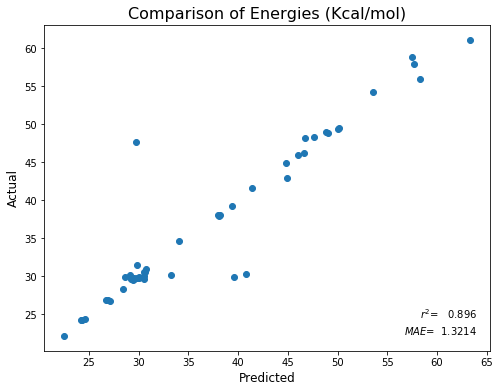

In [5]:
# plotting the actual vs. the predicted to get a visual representation
plt.figure(figsize=(8, 6))
plt.scatter(predicted, y_test)
plt.annotate('$r^2$=' + str(r2), xy=(0.97, 0.10),
             xycoords='axes fraction', ha='right')
plt.annotate('$MAE$=' + str("%8.4f" % mae), xy=(0.97, 0.05),
             xycoords='axes fraction', ha='right')
plt.title('Comparison of Energies (Kcal/mol)', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.grid(False)
plt.show()
